In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.stats import multivariate_normal
from math import sqrt
import seaborn as sns
from numpy import linalg as LA
import matplotlib.ticker as ticker
import pandas as pd

In [2]:
pd.set_option('precision', 5)
pd.options.display.float_format = '{:1.5f}'.format

In [3]:
class MyKalmanFilter:
    """
    Class that implements the Kalman Filter
    """
    def __init__(self, n_dim_state=2, n_dim_obs=2):
        """
        @param n_dim_state: dimension of the laten variables
        @param n_dim_obs: dimension of the observed variables
        """
        self.n_dim_state = n_dim_state
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = np.eye(n_dim_state)
        self.transition_covariance = np.eye(n_dim_state)
        self.observation_matrices = np.eye(n_dim_obs, n_dim_state)
        self.observation_covariance = np.eye(n_dim_obs)
        self.initial_state_mean = np.zeros(n_dim_state)
        self.initial_state_covariance = np.eye(n_dim_state)
        
        
    def sample(self, n_timesteps, initial_state=None, random_seed=None):
        """
        Method that gives samples
        @param initial_state: numpy array whose length == self.n_dim_state
        @param random_seed: an integer, for test purpose
        @output state: a 2d numpy array with dimension [n_timesteps, self.n_dim_state]
        @output observation: a 2d numpy array with dimension [n_timesteps, self.n_dim_obs]
        """
        
        if random_seed is not None:
            np.random.seed(random_seed)
            
        latent_state = np.zeros([n_timesteps, self.n_dim_state])
        observed_state = np.zeros([n_timesteps, self.n_dim_obs])
        
        ################
        ##### TODO #####
        ################
        # produce samples
        
        latent_state[0] = initial_state
        observed_state[0] = self.observation_matrices @ latent_state[0] + \
                np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance)
        
        for i in range(1, n_timesteps):
            latent_state[i] = self.transition_matrices @ latent_state[i-1] + \
                np.random.multivariate_normal(np.zeros(self.n_dim_state), self.transition_covariance)
            observed_state[i] = self.observation_matrices @ latent_state[i] + \
                np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance)
        
        return latent_state, observed_state

    def filter(self, X):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        # Validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # Create holders for outputs
        filtered_state_means = np.zeros( (n_example, self.n_dim_state) )
        filtered_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        # The first state mean and state covariance is the initial epectation.
        # Initialize internal variables.
        current_state_mean = self.initial_state_mean.copy()
        current_state_covar = self.initial_state_covariance.copy()
        self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))
        self.kalman_gains = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )

        for i in range(1, n_example):
            current_observed_data = X[i,:]
            
            # Run a single step forward filter:
            #   - Prediction step
            #   - Observation step
            #   - Update step
            #   - Populate holders

            # Prediction step
            predicted_state_mean = np.dot(
                self.transition_matrices, current_state_mean)
            predicted_state_cov = (
                np.matmul(
                    np.matmul(self.transition_matrices, current_state_covar),
                    np.transpose(self.transition_matrices)) + 
                self.transition_covariance)
            # Observation step
            innovation = (
                current_observed_data - 
                np.dot(self.observation_matrices, predicted_state_mean))
            innovation_covariance = (
                np.matmul(
                    np.matmul(
                        self.observation_matrices, predicted_state_cov), 
                    np.transpose(self.observation_matrices)) + 
                self.observation_covariance)
            # Update step
            kalman_gain = (
                np.matmul(
                    np.matmul(predicted_state_cov, np.transpose(self.observation_matrices)),
                    np.linalg.inv(innovation_covariance)))
            self.kalman_gains[i] = kalman_gain
            current_state_mean = predicted_state_mean + np.dot(kalman_gain, innovation)
            # Get the size of the matrix so we can make an identity matrix.
            size = current_state_covar.shape[0]
            current_state_covar = np.matmul(
                (np.eye(size)- 
                 np.matmul(kalman_gain,self.observation_matrices)), 
                predicted_state_cov)
            # Populate holders
            filtered_state_means[i, :] = current_state_mean
            filtered_state_covariances[i, :, :] = current_state_covar
            self.p_n_list[i, :, :] = predicted_state_cov
            
        return filtered_state_means, filtered_state_covariances
    
    
    def smooth(self, X):
        """
        Method that performs the Kalman Smoothing
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: smoothed_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: smoothed_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        # TODO: implement smoothing
        
        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim == self.n_dim_obs
        
        # run the forward path
        mu_list, v_list = self.filter(X)
        
        # create holders for outputs
        smoothed_state_means = np.zeros( (n_example, self.n_dim_state) )
        smoothed_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        # We are going to move backward, starting at t_{n-1} and we set up last time step t_n with 
        # the results of the forward pass.
        smoothed_state_means[-1] = mu_list[-1]
        smoothed_state_covariances[-1] = v_list[-1]
    
        #############################
        # TODO: implement smoothing #
        #############################
        
        self.f_list = []
            
        # We loop backward up to index 0 or time t_0.
        for i in range(n_example - 2, -1, -1):
            
            innovated_mean = mu_list[i]
            innovated_covariance = v_list[i]
            predicted_covariance = ((self.transition_matrices @ innovated_covariance)  @ self.transition_matrices.T) \
                + self.transition_covariance
            f_i = ((innovated_covariance @ self.transition_matrices.T) @ np.linalg.inv(predicted_covariance))
            self.f_list.append(f_i)            
            smoothed_mean = innovated_mean + \
                f_i @ (smoothed_state_means[i+1] - (self.transition_matrices @ innovated_mean))
            smoothed_covariance = innovated_covariance + \
                ((f_i @ (smoothed_state_covariances[i+1] - predicted_covariance)) @ f_i.T)

            # Update of estimates of latent variables.
            smoothed_state_means[i] = smoothed_mean
            smoothed_state_covariances[i] = smoothed_covariance

        # Add the last j_n
        predicted_covariance_n = ((self.transition_matrices @ v_list[-1]) @ np.linalg.inv(self.transition_matrices.T)) + \
            self.transition_covariance
        f_n = ((v_list[-1] @ self.transition_matrices.T) @ np.linalg.inv(predicted_covariance_n))
        self.f_list = list(reversed(self.f_list))
        self.f_list.append(f_n)    
        return smoothed_state_means, smoothed_state_covariances
    
    def em(self, X, max_iter=10):
        """
        This part is OPTIONAL
        Method that perform the EM algorithm to update the model parameters
        Note that in this exercise we ignore offsets
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @param max_iter: an integer indicating how many iterations to run
        """
        # validate inputs have right dimensions
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # keep track of log posterior (use function calculate_posterior below)
        self.avg_em_log_posterior = np.zeros(max_iter)*np.nan
        
               
        #############################
        #### TODO: EM iterations ####
        #############################
        
        for i_iter in range(max_iter):
            
            #1. Expectation Step
            # Smooth Kalman
            smoothed_state_means, smoothed_state_covariances = self.smooth(X)

            self.avg_em_log_posterior[i_iter] = np.nanmean(self.calculate_posterior(X, smoothed_state_means))
            
            # Update initial states and initial covariance
            self.initial_state_mean = smoothed_state_means[0]
            self.initial_state_covariance = smoothed_state_covariances[0]
            
            self.e_zn = []
            self.e_zn_znminus = []
            self.e_zn_zn = []
            for i in range(n_example):
                self.e_zn.append(smoothed_state_means[i])
                self.e_zn_zn.append(smoothed_state_covariances[i] + 
                                    np.outer(smoothed_state_means[i], smoothed_state_means[i]))
                if i != 0:
                    self.e_zn_znminus.append(np.dot(self.f_list[i-1], smoothed_state_covariances[i]) + \
                                            np.outer(smoothed_state_means[i], smoothed_state_means[i-1]))
                    
            # Maximization Step - Latent Dynamics
            ezy = np.sum(np.array(self.e_zn_znminus), 0)
            ezz = np.sum(np.array(self.e_zn_zn), 0)
            ezz_minus_n = ezz - self.e_zn_zn[-1]
            ezz_minus_1 = ezz - self.e_zn_zn[0]
        
            self.transition_matrices = np.dot(ezy, np.linalg.inv(ezz_minus_n))
            ezy_a = np.dot(ezz_minus_n, self.transition_matrices.T)
            self.transition_covariance = ezz_minus_1 - np.dot(self.transition_matrices, ezy)
            - np.dot(ezy, self.transition_matrices) + np.dot(self.transition_matrices, ezy_a)
            self.transition_covariance = 1.0/(n_example - 1) * self.transition_covariance
     

            # Maximization Step - Observations
            # Compute observation and observation covariance matrices
            x_zn = np.dot(X.T, np.array(self.e_zn))
            self.observation_matrices = np.dot(x_zn, np.linalg.inv(ezz.T))      
            self.observation_covariance = np.zeros((self.n_dim_obs, self.n_dim_obs))
            
            for t in range(n_example):
                err = (
                    X[t]
                    - np.dot(self.observation_matrices, smoothed_state_means[t])
                )
                self.observation_covariance += (np.outer(err, err) + np.dot(self.observation_matrices,
                         np.dot(smoothed_state_covariances[t],
                                self.observation_matrices.T)))
                
            self.observation_covariance = 1./n_example  * self.observation_covariance

    def import_param(self, kf_model):
        """
        Method that copies parameters from a trained Kalman Model
        @param kf_model: a Pykalman object
        """
        need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance', 
                  'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
        for param in need_params:
            setattr(self, param, getattr(kf_model, param))
            
            
    def calculate_posterior(self, X, state_mean, v_n=None):
        """
        Method that calculates the log posterior
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @param state_mean: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: a numpy 1D array whose dimension is [n_example]
        """
        
        if v_n is None:
            _, v_n = self.filter(X)
        llh = []
        for i in range(1,len(state_mean)):
            normal_mean = np.dot(self.observation_matrices, np.dot(self.transition_matrices, state_mean[i-1]))
            p_n = self.transition_matrices.dot(v_n[i].dot(self.transition_matrices))+self.transition_covariance
            #normal_cov = np.matmul(self.observation_matrices, np.matmul(self.p_n_list[i], self.observation_matrices.T)) + self.observation_covariance
            normal_cov = np.matmul(self.observation_matrices, np.matmul(p_n, self.observation_matrices.T)) + self.observation_covariance
            pdf_val = multivariate_normal.pdf(X[i], normal_mean, normal_cov)
            # replace 0 to prevent numerical underflow
            if pdf_val < 1e-10:
                pdf_val = 1e-10
            llh.append(np.log(pdf_val))            
        return np.array(llh)       

In [4]:
# Data Visualization
def plot_kalman(x,y,nx,ny,kx=None,ky=None, plot_type="r-", label=None, title='Parabola'):
    """
    Plot the trajectory
    """
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    if kx is not None and ky is not None:
        ax[0].plot(x,y,'g-',nx,ny,'b.',kx,ky, plot_type)
        ax[0].plot(kx[0], ky[0], 'or')
        ax[0].plot(kx[-1], ky[-1], 'xr')
        
        ax[1].plot(x, kx, '.k', label='latent dim 1')
        ax[1].plot(y, ky, '.', color='grey', label='latent dim 2')
        ax[1].set_xlabel('real latent')
        ax[1].set_ylabel('estimated latent')
        ax[1].legend()
    else:
        ax[0].plot(x,y,'g-',nx,ny,'b.')
        
        ax[1].plot(x, nx, '.k', label='dim 1')
        ax[1].plot(y, ny, '.', color='grey', label='dim 2')
        ax[1].set_xlabel('latent')
        ax[1].set_ylabel('observed')
        ax[1].legend()

    ax[0].set_xlabel('X position')
    ax[0].set_ylabel('Y position')
    ax[0].set_title(title)
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    
    if kx is not None and ky is not None and label is not None:
        ax[0].legend(('true','measured', label))
    else:
        ax[0].legend(('true','measured'))
    
    return fig
    
def visualize_line_plot(data, xlabel, ylabel, title):
    """
    Function that visualizes a line plot
    """
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def print_parameters(kf_model, need_params=None, evals=False):
    """
    Function that prints out the parameters for a Kalman Filter
    @param - kf_model : the model object
    @param - need_params : a list of string
    """
    if evals:
        if need_params is None:
            need_params1 = ['transition_matrices', 'transition_covariance', 'observation_covariance', 'initial_state_covariance']
            need_params2 = ['observation_matrices', 'initial_state_mean']
        for param in need_params1: 
            tmp = np.linalg.eig(getattr(kf_model, param))[0]
            print("{0} = {1}, shape = {2}\n".format(param, tmp, tmp.shape))
        for param in need_params2: 
            print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))
    else:
        if need_params is None:
            need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance', 'observation_covariance', 
                            'initial_state_mean', 'initial_state_covariance']
        for param in need_params: 
            print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))
    

In [5]:
n_dim_state = 2 # two states
n_dim_obs = 2 # two observations
transition_matrices = np.array([[0.65, 0.3],[0.2, 0.8]])
observation_matrices = np.array([[1.1, 0.2], [0.5, 0.95]])
initial_state_mean = np.zeros(n_dim_state)
initial_state_covariance = 0.5 * np.eye(n_dim_state)
transition_covariance = 0.1 * np.eye(n_dim_state)
observation_covariance = 0.01 * np.eye(n_dim_obs)

In [6]:
kf = MyKalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
# set paramters
kf.transition_matrices = transition_matrices
kf.transition_covariance = transition_covariance
kf.observation_matrices = observation_matrices
kf.observation_covariance = observation_covariance
kf.initial_state_mean = initial_state_mean
kf.initial_state_covariance = initial_state_covariance
# print the parameters
print_parameters(kf, evals=False)

transition_matrices = [[0.65 0.3 ]
 [0.2  0.8 ]], shape = (2, 2)

observation_matrices = [[1.1  0.2 ]
 [0.5  0.95]], shape = (2, 2)

transition_covariance = [[0.1 0. ]
 [0.  0.1]], shape = (2, 2)

observation_covariance = [[0.01 0.  ]
 [0.   0.01]], shape = (2, 2)

initial_state_mean = [0. 0.], shape = (2,)

initial_state_covariance = [[0.5 0. ]
 [0.  0.5]], shape = (2, 2)



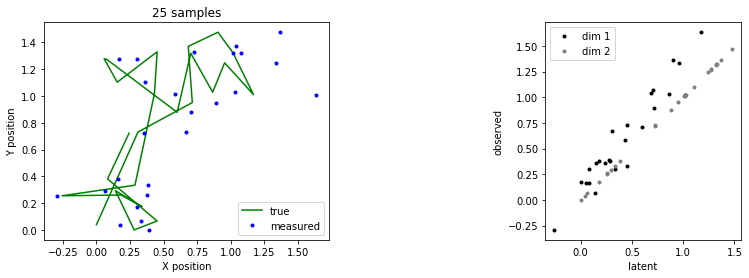

In [7]:
n_points = 25
sampled_states, sampled_observations = kf.sample(n_points, initial_state=kf.initial_state_mean, random_seed=0)
fig = plot_kalman(sampled_states[:,0],sampled_observations[:,1],sampled_observations[:,0],sampled_observations[:,1], title="{} samples".format(n_points));

In [8]:
n_samples = sampled_observations.shape[0]

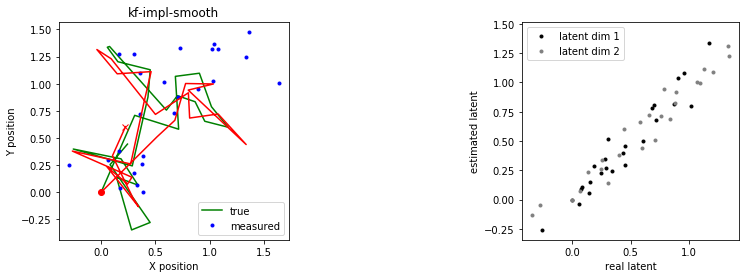

In [9]:
smoothed_state_means, smoothed_state_covariances = kf.smooth(sampled_observations)
fig = plot_kalman(sampled_states[:,0],sampled_states[:,1],sampled_observations[:,0],sampled_observations[:,1], 
                  smoothed_state_means[:,0], smoothed_state_means[:,1], "r-", title="kf-impl-smooth")
plt.axis('square');

In [10]:
def plot_mean_var_values(means, var_values, xlabel, ylabel, title1, title2, plot_type="r-"):

    fig, ax = plt.subplots(2,2, figsize=(15, 8))
    fig.subplots_adjust(hspace=.5)
    ax[0, 0].plot(np.arange(means[:, 0].shape[0]), means[:, 0], ".g")
    ax[0, 0].set_xlabel(xlabel)
    ax[0, 0].set_ylabel(ylabel)
    ax[0, 0].set_title(title1)
    ax[0, 0].legend(["Kalman Gain Latent 1"])
    start, end = min(means[:, 0]), max(means[:, 0])  + 0.05
    ax[0, 0].yaxis.set_ticks(np.arange(start, end, 0.05))
    ax[0, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    ax[0, 1].plot(np.arange(means[:, 1].shape[0]), means[:, 1], ".r") 
    ax[0, 1].set_xlabel(xlabel)
    ax[0, 1].set_ylabel(ylabel)
    ax[0, 1].set_title(title1)
    ax[0, 1].legend(["Kalman Gain Latent 2"])
    ax[0, 1].yaxis.set_ticks(np.arange(start, end, 0.05))
    ax[0, 1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    ax[1, 0].plot(np.arange(var_values[:, 0].shape[0]), var_values[:, 0], ".g")
    ax[1, 0].set_xlabel(xlabel)
    ax[1, 0].set_ylabel(ylabel)
    ax[1, 0].set_title(title2)
    ax[1, 0].legend(["Latent 1"])
    start, end = min(var_values[:, 0]), max(var_values[:, 0]) + 0.05
    ax[1, 0].yaxis.set_ticks(np.arange(start, end, 0.05))
    ax[1, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    ax[1, 1].plot(np.arange(var_values[:, 1].shape[0]), var_values[:, 1], ".r") 
    ax[1, 1].set_xlabel(xlabel)
    ax[1, 1].set_ylabel(ylabel)
    ax[1, 1].set_title(title2)
    ax[1, 1].legend(["Latent 2"])
    ax[1, 1].yaxis.set_ticks(np.arange(start, end, 0.05))
    ax[1, 1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    sns.despine()
    plt.show()

In [11]:
def compute_mean_var(k_array):
    n_samples= k_array.shape[0]
    means = np.zeros((n_samples, 2))
    var_values = np.zeros((n_samples, 2))
    for i in range(n_samples):
        k_matrix = k_array[i]
        means[i] = np.mean(k_matrix, axis=0)
        var_values[i] =  np.var(k_matrix, axis=0)
    return means, var_values

In [12]:
def compute_frobenius(k_array):
    n_samples= k_array.shape[0]
    norms = np.zeros(n_samples)
    for i in range(n_samples):
        k = k_array[i]
        norms[i] = LA.norm(k, "fro")
    return norms

In [13]:
def plot_frobenius_norms(k_norms, f_norms):
    
    fig, ax = plt.subplots(1,2, figsize=(10, 4))
    fig.subplots_adjust(wspace=.5)
    ax[0].plot(np.arange(k_norms.size), k_norms, "*r")
    ax[0].set_xlabel("time step")
    ax[0].set_ylabel("K")
    ax[0].set_title("K Frobenius Norm")
    ax[0].legend(["K Frobenius Norm"], loc = "lower right")
    start, end = min(k_norms), max(k_norms)  + 0.1
    ax[0].yaxis.set_ticks(np.arange(start, end, 0.1))
    ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))
    
    ax[1].plot(np.arange(f_norms.size), f_norms, "*b")
    ax[1].set_xlabel("time step")
    ax[1].set_ylabel("F")
    ax[1].set_title("F Frobenius Norm")
    ax[1].legend(["F Frobenius Norm"], loc = "lower right")
    start, end = min(f_norms), max(f_norms)  + 0.1
    ax[1].yaxis.set_ticks(np.arange(start, end, 0.1))
    ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))
    plt.show()

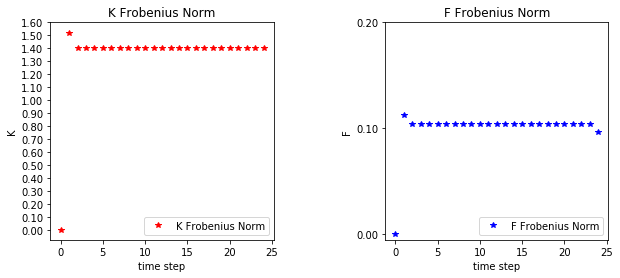

In [14]:
k_norms = compute_frobenius(kf.kalman_gains)
f_norms = compute_frobenius(np.array(kf.f_list))
plot_frobenius_norms(k_norms, f_norms)

In [15]:
kalman_gain_means, kalman_gain_var = compute_mean_var(kf.kalman_gains)

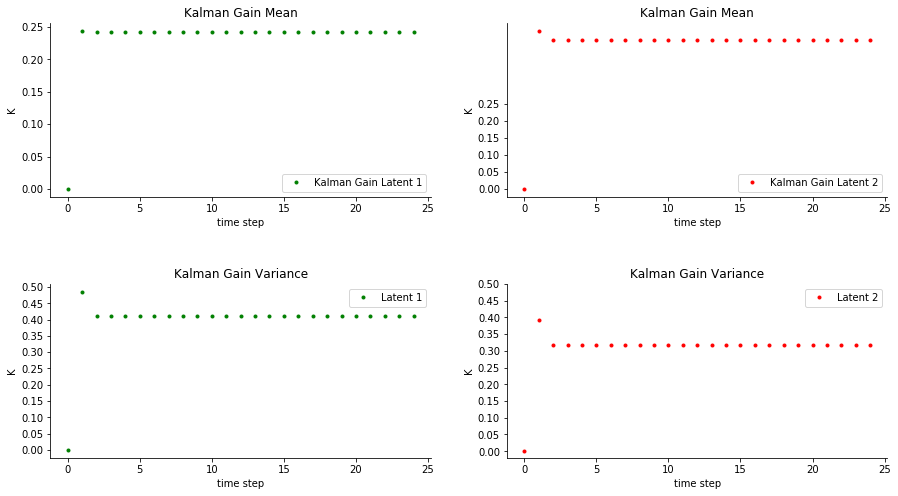

In [16]:
plot_mean_var_values(kalman_gain_means, kalman_gain_var, "time step", "K", "Kalman Gain Mean", "Kalman Gain Variance")

In [17]:
transition_matrices = np.eye(kf.n_dim_state)
observation_matrices = np.eye(n_dim_state)
initial_state_mean = np.zeros(n_dim_state)
initial_state_covariance = np.eye(kf.n_dim_state)*.1
transition_covariance = np.eye(n_dim_obs)
observation_covariance = np.eye(n_dim_obs)*.1

In [18]:
kf = MyKalmanFilter(n_dim_state=n_dim_state, n_dim_obs= n_dim_obs)
kf.transition_matrices = transition_matrices
kf.transition_covariance = transition_covariance
kf.observation_matrices = observation_matrices
kf.observation_covariance = observation_covariance
kf.initial_state_mean = initial_state_mean
kf.initial_state_covariance = initial_state_covariance

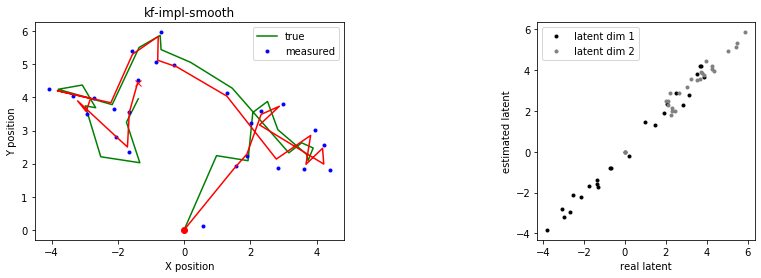

In [19]:
n_points = 25
sampled_states, sampled_observations = kf.sample(n_points, initial_state=kf.initial_state_mean, random_seed=0)
smoothed_state_means, smoothed_state_covariances = kf.smooth(sampled_observations)
fig = plot_kalman(sampled_states[:,0],sampled_states[:,1],sampled_observations[:,0],sampled_observations[:,1], 
                  smoothed_state_means[:,0], smoothed_state_means[:,1], "r-", title="kf-impl-smooth")
plt.axis('square');

In [20]:
# kalman_gain_means, kalman_gain_var = compute_mean_var(kf.kalman_gains)
# plot_mean_var_values(kalman_gain_means, kalman_gain_var, "time step", "K", "Kalman Gain Mean", "Kalman Gain Variance")

In [21]:
obscov_old = kf.observation_covariance.copy()

# plot
n_iter = 4
stats = []
for nn in range(n_iter):
    sampled_states, sampled_observations = kf.sample(n_points, initial_state=kf.initial_state_mean, random_seed=nn)
    smoothed_state_means, smoothed_state_covariances = kf.smooth(sampled_observations)
    k_norms = compute_frobenius(kf.kalman_gains)
    f_norms =  compute_frobenius(np.array(kf.f_list))
    stats.append((k_norms.mean(), k_norms.var(), f_norms.mean(), f_norms.var()))
    scaled_observation_covariance = obscov_old * 10**(-nn)
    kf.observation_covariance = scaled_observation_covariance
kf.observation_covariance = obscov_old
df = pd.DataFrame(stats, columns = ["K-Norm-Mean", "K-Norm-Var", "F-Norm-Mean", "F-Norm-Var"]) 

# As we reduce the observation noise the Kalman Gain and the F "Gain" decrease.

In [22]:
df

,K-Norm-Mean,K-Norm-Var,F-Norm-Mean,F-Norm-Var
0,1.24374,0.06445,0.11394,0.00054
1,1.24374,0.06445,0.11394,0.00054
2,1.34438,0.07531,0.01331,0.00001
3,1.35630,0.07665,0.00135,0.00000


In [23]:
trans_old = kf.transition_matrices.copy()

# plot
n_iter = 4
stats = []
for nn in range(n_iter):
    sampled_states, sampled_observations = kf.sample(n_points, initial_state=kf.initial_state_mean, random_seed=nn)
    smoothed_state_means, smoothed_state_covariances = kf.smooth(sampled_observations)
    k_norms = compute_frobenius(kf.kalman_gains)
    f_norms =  compute_frobenius(np.array(kf.f_list))
    stats.append((k_norms.mean(), k_norms.var(), f_norms.mean(), f_norms.var()))
    scaled_transition = trans_old * 10**(nn)
    kf.transition_matrices = scaled_transition
kf.transition_matrices = trans_old
df = pd.DataFrame(stats, columns = ["K-Norm-Mean", "K-Norm-Var", "F-Norm-Mean", "F-Norm-Var"]) 

# As we increase the temporal dynamics (transition matrix) the Kalman Gain and F increase.

In [24]:
df

,K-Norm-Mean,K-Norm-Var,F-Norm-Mean,F-Norm-Var
0,1.24374,0.06445,0.11394,0.00054
1,1.24374,0.06445,0.11394,0.00054
2,1.34532,0.07541,0.16918,0.05159
3,1.35751,0.07678,0.52721,6.33260


In [25]:
obs_old = kf.observation_matrices.copy()

# plot
n_iter = 4
stats = []
for nn in range(n_iter):
    sampled_states, sampled_observations = kf.sample(n_points, initial_state=kf.initial_state_mean, random_seed=nn)
    smoothed_state_means, smoothed_state_covariances = kf.smooth(sampled_observations)
    k_norms = compute_frobenius(kf.kalman_gains)
    f_norms =  compute_frobenius(np.array(kf.f_list))
    stats.append((k_norms.mean(), k_norms.var(), f_norms.mean(), f_norms.var()))
    scaled_observation = obs_old * 10**(nn)
    kf.observation_matrices = scaled_observation
kf.observation_matrices = obs_old
df = pd.DataFrame(stats, columns = ["K-Norm-Mean", "K-Norm-Var", "F-Norm-Mean", "F-Norm-Var"]) 

# As we increase the observation dynamics the Kalman Gain and F decrease.

In [26]:
df

,K-Norm-Mean,K-Norm-Var,F-Norm-Mean,F-Norm-Var
0,1.24374,0.06445,0.11394,0.00054
1,1.24374,0.06445,0.11394,0.00054
2,0.13563,0.00077,0.00135,0.00000
3,0.01358,0.00001,0.00001,0.00000
